In [1]:
from sea_breeze import load_model_data, utils, sea_breeze_funcs
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import logging
import datetime as dt
import pandas as pd

logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
def preprocess(ds):
    ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=11)
    #return ds["mask"].resample({"time":"1D"}).max()
    return ds["mask"].groupby(ds.time.dt.date).max()

def load_hourly(model,lat_slice,lon_slice,diagnostic,lt_offset,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr").sel(lat=lat_slice,lon=lon_slice)
    ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=lt_offset)
    
    return ds

def count_num_of_objs(da):
    x = np.unique(da)
    x = x[x!=0]
    x = x[~np.isnan(x)]
    return len(x)

def mask(ds,angle_ds,mask=True,mask_thresh=0.5):
    return xr.where(angle_ds.variance_interp<mask_thresh, ds, np.nan)  

In [3]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39553,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:38111,Total threads: 2
Dashboard: /proxy/43267/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:41925,


In [5]:
#lat_slice, lon_slice = utils.get_perth_large_bounds()
lat_slice = slice(-36,-30)
lon_slice = slice(113,119)

In [6]:
m="aus2200"
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,
    path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
    lat_slice=lat_slice,
    lon_slice=lon_slice
)
orog,lsm = load_model_data.load_aus2200_static("mjo-elnino2016",lon_slice,lat_slice)   

lst_offset = np.round(np.mean(lsm.lon.values) / 180 * 12)

m = "aus2200_smooth_s4"
c = {"time":24,"lat":-1,"lon":-1}


In [7]:
F_hourly = load_hourly(m,lat_slice,lon_slice,"F",lst_offset,chunks=c)
#F_hourly = xr.where((F_hourly.time.dt.hour < 9) | (F_hourly.time.dt.hour > 21), 0, F_hourly)
F = F_hourly.groupby(F_hourly.time.dt.date).max().persist()

h_hourly = load_hourly(m,lat_slice,lon_slice,"fuzzy",lst_offset,chunks=c)
#h_hourly = xr.where((h_hourly.time.dt.hour < 9) | (h_hourly.time.dt.hour > 21), 0, h_hourly)
h = h_hourly.groupby(h_hourly.time.dt.date).max().persist()

sbi_hourly = load_hourly(m,lat_slice,lon_slice,"sbi",lst_offset,chunks=c)
#sbi_hourly = xr.where((sbi_hourly.time.dt.hour < 9) | (sbi_hourly.time.dt.hour > 21), 0, sbi_hourly)
sbi = sbi_hourly.groupby(sbi_hourly.time.dt.date).max().persist()


In [8]:
F_coarse = F.mask.rolling({"lat":23,"lon":23},center=True,min_periods=11).max().persist()
h_coarse = h.mask.rolling({"lat":23,"lon":23},center=True,min_periods=11).max().persist()
sbi_coarse = sbi.mask.rolling(dim={"lat":23,"lon":23},center="True",min_periods=11).max().persist()

In [9]:
#Perth airport
#perth_lat, perth_lon = -31.9275, 115.9764

# F_sb_ts = F_coarse.sel(lat=perth_lat,lon=perth_lon,method="nearest").values
# h_sb_ts = h_coarse.sel(lat=perth_lat,lon=perth_lon,method="nearest").values
# sbi_sb_ts = sbi_coarse.sel(lat=perth_lat,lon=perth_lon,method="nearest").values

#Change to close coastline point just using point value (no rolling max)
perth_ap_lat = -31.9275
perth_ap_lon = 115.9764

#Define perth point as Swanbourne AWS. Close enough to coast so that there is a high number of frontal objects here, but it still a land point in AUS2200
# perth_lat = -31.9560
# perth_lon = 115.7619

#Define perth point as Ocean Reef AWS.
perth_lat = -31.7594
perth_lon = 115.7278

F_sb_ts = F.mask.sel(lat=perth_lat,lon=perth_lon,method="nearest").values
h_sb_ts = h.mask.sel(lat=perth_lat,lon=perth_lon,method="nearest").values
sbi_sb_ts = sbi.mask.sel(lat=perth_lat,lon=perth_lon,method="nearest").values



In [10]:
print("Perth coast days: ",F.mask.sel(lat=perth_lat,lon=perth_lon,method="nearest").values.sum())
print("Perth airport days: ",F.mask.sel(lat=perth_ap_lat,lon=perth_ap_lon,method="nearest").values.sum())

Perth coast days:  96
Perth airport days:  47


In [11]:
print("Perth coast freq: ",F.mask.sel(lat=perth_lat,lon=perth_lon,method="nearest").values.sum() / 181)
print("Perth airport freq: ",F.mask.sel(lat=perth_ap_lat,lon=perth_ap_lon,method="nearest").values.sum() / 181)

Perth coast freq:  0.5303867403314917
Perth airport freq:  0.2596685082872928


In [12]:
print(np.mean(F_sb_ts), np.mean(h_sb_ts), np.mean(sbi_sb_ts))

0.5303867403314917 0.016574585635359115 0.03314917127071823


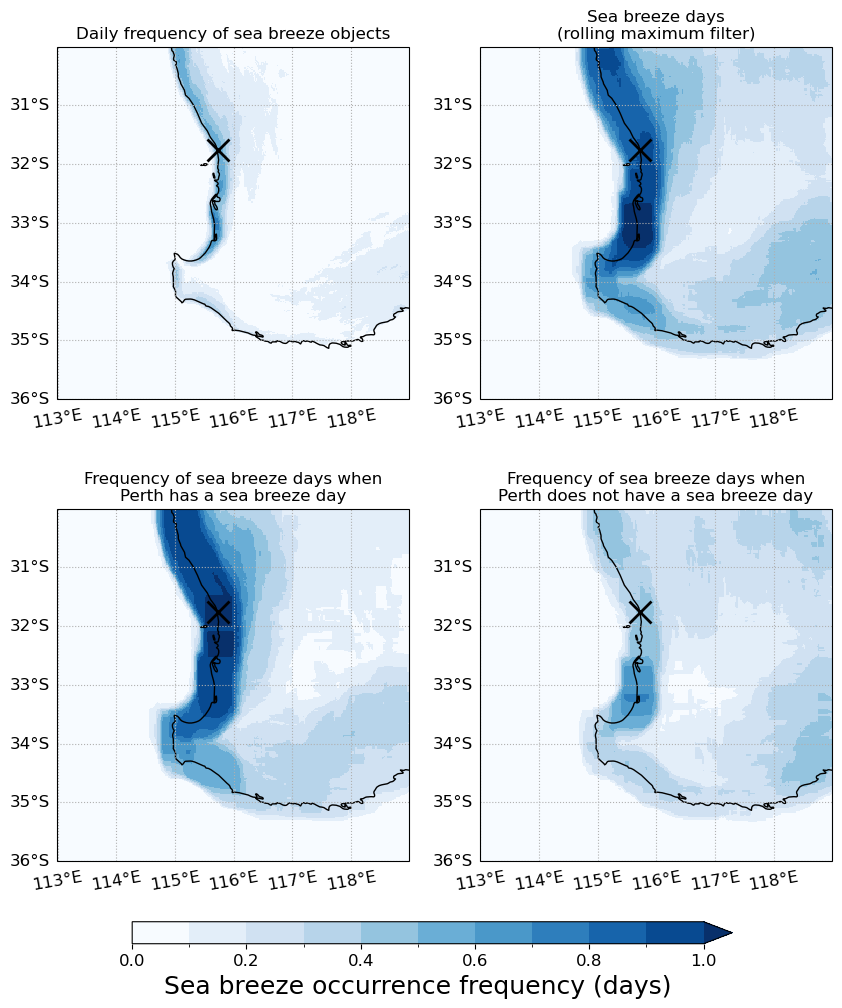

In [13]:
plt.figure(figsize=[10,11])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
F.mask.mean("date").plot(vmax=1,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Daily frequency of sea breeze objects")

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
F_coarse.mean("date").plot(vmax=0.8,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Sea breeze days\n(rolling maximum filter)")

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
(F_coarse.isel(date=F_sb_ts==1).mean("date")).plot(vmax=1,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Frequency of sea breeze days when\nPerth has a sea breeze day")

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
c=(F_coarse.isel(date=F_sb_ts==0).mean("date")).plot(vmax=1,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Frequency of sea breeze days when\nPerth does not have a sea breeze day")

cb=plt.colorbar(c,cax=plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cb.set_label("Sea breeze occurrence frequency (days)",size=18)

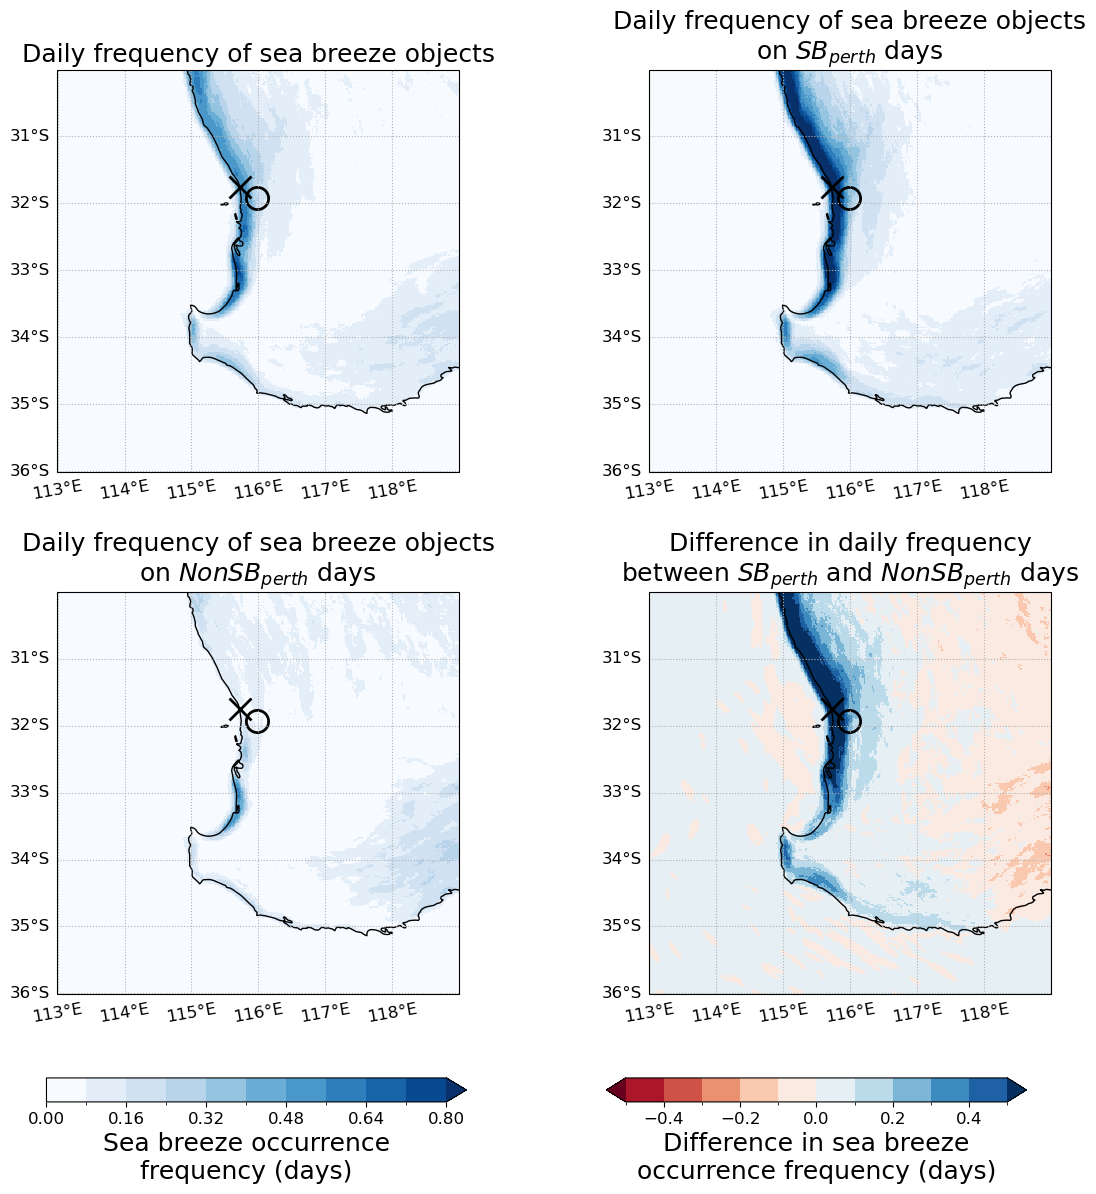

In [14]:
plt.figure(figsize=[14,12])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
F.mask.mean("date").plot(vmax=0.8,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
plt.plot(perth_ap_lon,perth_ap_lat,marker="o",color="k",ms=16,mew=2,mfc="none")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Daily frequency of sea breeze objects",size=18)

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
(F.mask.isel(date=F_sb_ts==1).mean("date")).plot(vmax=0.8,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
plt.plot(perth_ap_lon,perth_ap_lat,marker="o",color="k",ms=16,mew=2,mfc="none")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Daily frequency of sea breeze objects\non $SB_{perth}$ days",size=18)

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
c1=(F.mask.isel(date=F_sb_ts==0).mean("date")).plot(vmax=0.8,levels=11,cmap="Blues",add_colorbar=False,extend="max")
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
plt.plot(perth_ap_lon,perth_ap_lat,marker="o",color="k",ms=16,mew=2,mfc="none")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Daily frequency of sea breeze objects\non $NonSB_{perth}$ days",size=18)

ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
c2=((F.mask.isel(date=F_sb_ts==1).mean("date")) - (F.mask.isel(date=F_sb_ts==0).mean("date"))).plot(vmin=-0.5,vmax=0.5,levels=11,cmap="RdBu",extend="both",add_colorbar=False)
plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=16,mew=2)
plt.plot(perth_ap_lon,perth_ap_lat,marker="o",color="k",ms=16,mew=2,mfc="none")
ax.coastlines()
ax.gridlines(draw_labels=["left","bottom"],ls=":",xlabel_style={"size":12,"rotation":10},ylabel_style={"size":12})
plt.title("Difference in daily frequency\nbetween $SB_{perth}$ and $NonSB_{perth}$ days",size=18)


cb=plt.colorbar(c1,cax=plt.axes([0.15,0.02,0.3,0.02]),orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cb.set_label("Sea breeze occurrence\nfrequency (days)",size=18)

cb=plt.colorbar(c2,cax=plt.axes([0.55,0.02,0.3,0.02]),orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cb.set_label("Difference in sea breeze\noccurrence frequency (days)",size=18)

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/perth_composite_objects.jpeg",dpi=500,bbox_inches="tight")

In [15]:
#Load model data for the period
uas = []
vas = []
tas = []
hus = []
times = [("2013-01-01 00:00","2013-02-28 23:00"),
         ("2016-01-01 00:00","2016-02-29 23:00"),
         ("2018-01-01 00:00","2018-02-28 23:00")]
expid = ["mjo-neutral2013","mjo-elnino2016","mjo-lanina2018"]
chunks = {"time":1,"lat":-1,"lon":-1}
for t,e in zip(times,expid):

    vas.append(load_model_data.load_aus2200_variable(
                "vas",
                t[0],
                t[1],
                e,
                lon_slice,
                lat_slice,
                "1hr",
                staggered="lat",
                chunks=chunks))

    uas.append(load_model_data.load_aus2200_variable(
                "uas",
                t[0],
                t[1],
                e,
                lon_slice,
                lat_slice,
                staggered="lon",
                freq="1hr",
                chunks=chunks))

    tas.append(load_model_data.load_aus2200_variable(
                "tas",
                t[0],
                t[1],
                e,
                lon_slice,
                lat_slice,
                freq="1hr",
                chunks=chunks))

    hus.append(load_model_data.load_aus2200_variable(
                "huss",
                t[0],
                t[1],
                e,
                lon_slice,
                lat_slice,
                freq="1hr",
                chunks=chunks))
    
vas = xr.concat(vas,dim="time")
uas = xr.concat(uas,dim="time")
tas = xr.concat(tas,dim="time")
hus = xr.concat(hus,dim="time")

#Add local time offset
uas["time"] = pd.to_datetime(uas.time) + dt.timedelta(hours=lst_offset)
vas["time"] = pd.to_datetime(vas.time) + dt.timedelta(hours=lst_offset)
tas["time"] = pd.to_datetime(tas.time) + dt.timedelta(hours=lst_offset)
hus["time"] = pd.to_datetime(hus.time) + dt.timedelta(hours=lst_offset)    

#Composite the model data over the sea breeze days defined by F
sb_hourly_times = (np.in1d(uas.time.dt.date,F.date[F_sb_ts.astype(bool)]))
tas_F_sb_comp = tas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
hus_F_sb_comp = hus.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
vas_F_sb_comp = vas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
uas_F_sb_comp = uas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
uprime_F_sb_comp,vprime_F_sb_comp=sea_breeze_funcs.rotate_wind(uas_F_sb_comp,vas_F_sb_comp,angle_ds.angle_interp)
F_sb_comp = {"tas":tas_F_sb_comp,
             "hus":hus_F_sb_comp,
             "uas":uas_F_sb_comp,
             "vas":vas_F_sb_comp,
             "vprime":vprime_F_sb_comp}

#Composite the model data over non sea breeze days defined by F
nonsb_hourly_times = (np.in1d(uas.time.dt.date,F.date[~F_sb_ts.astype(bool)]))
hus_F_nonsb_comp = hus.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
tas_F_nonsb_comp = tas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
vas_F_nonsb_comp = vas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
uas_F_nonsb_comp = uas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
uprime_F_nonsb_comp,vprime_F_nonsb_comp=sea_breeze_funcs.rotate_wind(uas_F_nonsb_comp,vas_F_nonsb_comp,angle_ds.angle_interp)    
F_non_sb_comp = {"tas":tas_F_nonsb_comp,
             "hus":hus_F_nonsb_comp,
             "uas":uas_F_nonsb_comp,
             "vas":vas_F_nonsb_comp,
             "vprime":vprime_F_nonsb_comp}

#Composite the model data over sea breeze days defined by sbi
sb_hourly_times = (np.in1d(uas.time.dt.date,sbi.date[sbi_sb_ts.astype(bool)]))
tas_sbi_sb_comp = tas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
hus_sbi_sb_comp = hus.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
vas_sbi_sb_comp = vas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
uas_sbi_sb_comp = uas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
uprime_sbi_sb_comp,vprime_sbi_sb_comp=sea_breeze_funcs.rotate_wind(uas_sbi_sb_comp,vas_sbi_sb_comp,angle_ds.angle_interp)
sbi_sb_comp = {"tas":tas_sbi_sb_comp,
             "hus":hus_sbi_sb_comp,
             "uas":uas_sbi_sb_comp,
             "vas":vas_sbi_sb_comp,
             "vprime":vprime_sbi_sb_comp}

#Composite the model data over non sea breeze days defined by sbi
non_sb_hourly_times = (np.in1d(uas.time.dt.date,sbi.date[~sbi_sb_ts.astype(bool)]))
hus_sbi_nonsb_comp = hus.sel(time=non_sb_hourly_times).groupby("time.hour").mean().persist()
tas_sbi_nonsb_comp = tas.sel(time=non_sb_hourly_times).groupby("time.hour").mean().persist()
vas_sbi_nonsb_comp = vas.sel(time=non_sb_hourly_times).groupby("time.hour").mean().persist()
uas_sbi_nonsb_comp = uas.sel(time=non_sb_hourly_times).groupby("time.hour").mean().persist()
uprime_sbi_nonsb_comp,vprime_sbi_nonsb_comp=sea_breeze_funcs.rotate_wind(uas_sbi_nonsb_comp,vas_sbi_nonsb_comp,angle_ds.angle_interp)
sbi_nonsb_comp = {"tas":tas_sbi_nonsb_comp,
             "hus":hus_sbi_nonsb_comp,
             "uas":uas_sbi_nonsb_comp,
             "vas":vas_sbi_nonsb_comp,
             "vprime":vprime_sbi_nonsb_comp}

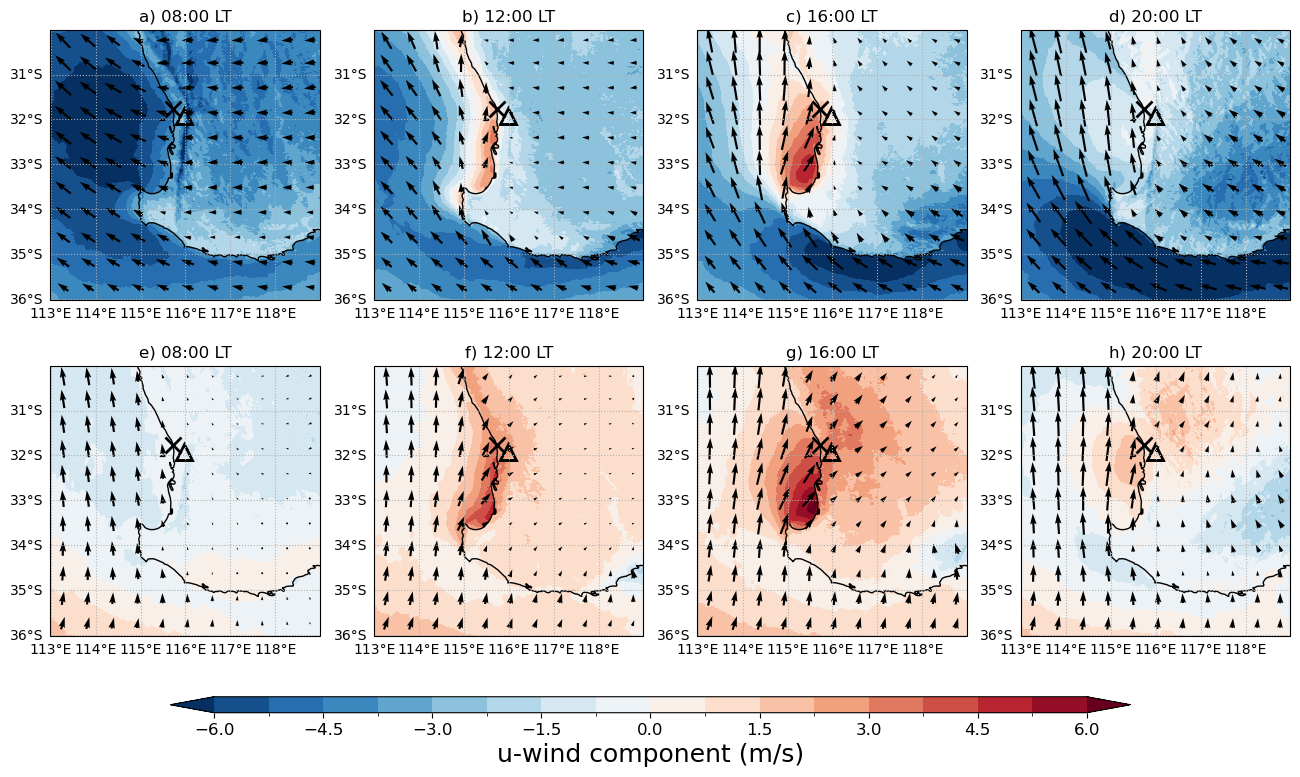

In [18]:

width=0.008
vmin=-6
vmax=6
c=28
s=100

def plot(ds,hour,ax,vmin,vmax,c,s,width,title):
    cplot=ds["uas"].sel(hour=hour).plot(cmap="RdBu_r",ax=ax,vmin=vmin,vmax=vmax,add_colorbar=False,extend="both",levels=17)
    xr.Dataset({
        "u":ds["uas"],
        "v":ds["vas"]}).coarsen({"lat":c,"lon":c},boundary="pad").mean().sel(hour=hour).plot.quiver(
        x="lon",y="lat",u="u",v="v",ax=ax,width=width,scale=s,add_guide=False)
    ax.coastlines()
    #plot_sbdays_box(angle_ds,sb_lat_slice,sb_lon_slice)
    plt.plot(perth_lon,perth_lat,marker="x",color="k",ms=12,mew=2,mfc="none")
    plt.plot(perth_ap_lon,perth_ap_lat,marker="^",color="k",ms=12,mew=2,mfc="none")
    ax.gridlines(draw_labels=["left","bottom"],ls=":")
    plt.title(title+" LT")

    return cplot

plt.figure(figsize=[16,8])

ax=plt.subplot(2,4,1,projection=ccrs.PlateCarree())
plot(F_sb_comp,8,ax,vmin,vmax,c,s,width,"a) 08:00")

ax=plt.subplot(2,4,2,projection=ccrs.PlateCarree())
plot(F_sb_comp,12,ax,vmin,vmax,c,s,width,"b) 12:00")

ax=plt.subplot(2,4,3,projection=ccrs.PlateCarree())
plot(F_sb_comp,16,ax,vmin,vmax,c,s,width,"c) 16:00")

ax=plt.subplot(2,4,4,projection=ccrs.PlateCarree())
plot(F_sb_comp,20,ax,vmin,vmax,c,s,width,"d) 20:00")




ax=plt.subplot(2,4,5,projection=ccrs.PlateCarree())
plot(F_non_sb_comp,8,ax,vmin,vmax,c,s,width,"e) 08:00")

ax=plt.subplot(2,4,6,projection=ccrs.PlateCarree())
plot(F_non_sb_comp,12,ax,vmin,vmax,c,s,width,"f) 12:00")

ax=plt.subplot(2,4,7,projection=ccrs.PlateCarree())
plot(F_non_sb_comp,16,ax,vmin,vmax,c,s,width,"g) 16:00")

ax=plt.subplot(2,4,8,projection=ccrs.PlateCarree())
cplot=plot(F_non_sb_comp,20,ax,vmin,vmax,c,s,width,"h) 20:00")

cb=plt.colorbar(cplot,cax=plt.axes([0.2,0.02,0.6,0.02]),orientation="horizontal",extend="both")
cb.ax.tick_params(labelsize=12)
cb.set_label("u-wind component (m/s)",size=18)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/perth_composite_wind.jpeg",dpi=500,bbox_inches="tight")

In [24]:
utils.get_perth_bounds()

(slice(-33.7406830440922, -31.0427169559078, None),
 slice(114.269565254344, 117.464434745656, None))

In [34]:
sb_lat_slice = slice(-33,-31)
sb_lon_slice = slice(114,116)

coastal_mask = (~lsm) & \
        (angle_ds.min_coast_dist.lat<sb_lat_slice.stop) & \
        (angle_ds.min_coast_dist.lat>sb_lat_slice.start) & \
        (angle_ds.min_coast_dist.lon>sb_lon_slice.start) & \
        (angle_ds.min_coast_dist.lon<sb_lon_slice.stop) & \
        (angle_ds.min_coast_dist<=50)

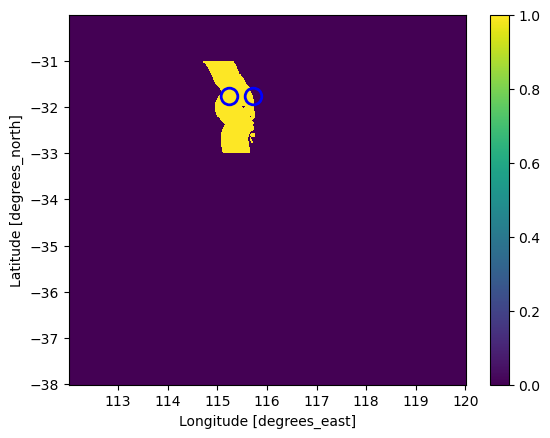

In [35]:
coastal_mask.plot()
plt.plot(perth_lon,perth_lat,marker="o",color="blue",ms=12,mew=2,mfc="none")
plt.plot(perth_lon-0.5,perth_lat,marker="o",color="blue",ms=12,mew=2,mfc="none")

In [32]:
from sea_breeze import load_obs
slices = [slice("2013-01-01","2013-03-01"),slice("2016-01-01","2016-03-01"),slice("2018-01-01","2018-03-01")]
obs = []
for s in slices:
    print(s)
    temp = load_obs.load_half_hourly_stn_obs("WA",s)
    obs.append(temp.sel(station=9214))

obs = xr.concat(obs,dim="time")
obs["time"] = pd.to_datetime(obs.time) + dt.timedelta(hours=lst_offset)

sb_hourly_times = (np.in1d(obs.time.dt.date,F.date[F_sb_ts.astype(bool)]))
non_sb_hourly_times = (np.in1d(obs.time.dt.date,F.date[~F_sb_ts.astype(bool)]))
obs_sb_hourly = obs.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
obs_non_sb_hourly = obs.sel(time=non_sb_hourly_times).groupby("time.hour").mean().persist()

slice('2013-01-01', '2013-03-01', None)
slice('2016-01-01', '2016-03-01', None)
slice('2018-01-01', '2018-03-01', None)


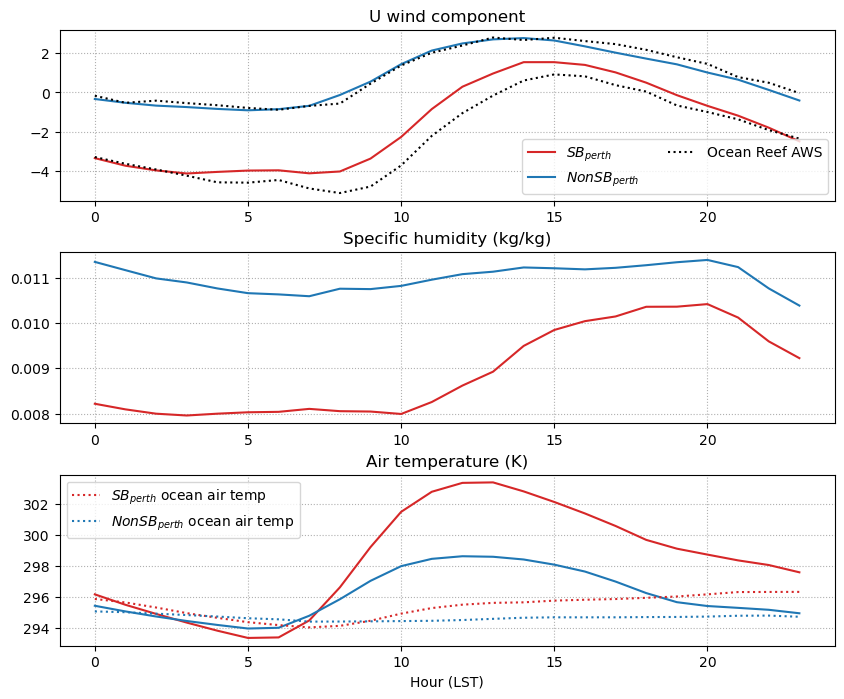

In [33]:
plt.figure(figsize=[10,8])
ax=plt.subplot(3,1,1)
l1=F_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:red")
l2=F_non_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:blue")
l3=obs_sb_hourly.u.plot(color="k",ls=":")
obs_non_sb_hourly.u.plot(color="k",ls=":")
ax.grid(ls=":")
ax.set_xlabel("")
ax.set_title("U wind component")
plt.ylabel("")
plt.legend([l1[0],l2[0],l3[0]],["$SB_{perth}$","$NonSB_{perth}$","Ocean Reef AWS"],ncols=2,loc="lower right")

ax=plt.subplot(3,1,2)
l1=F_sb_comp["hus"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:red")
l2=F_non_sb_comp["hus"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:blue")
ax.grid(ls=":")
ax.set_xlabel("")
ax.set_title("Specific humidity (kg/kg)")
plt.ylabel("")


ax=plt.subplot(3,1,3)
F_sb_comp["tas"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:red")
F_non_sb_comp["tas"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:blue")
l1=F_sb_comp["tas"].sel(lat=perth_lat,lon=perth_lon-0.5,method="nearest").plot(color="tab:red",ls=":")
l2=F_non_sb_comp["tas"].sel(lat=perth_lat,lon=perth_lon-0.5,method="nearest").plot(color="tab:blue",ls=":")
ax.grid(ls=":")
ax.set_xlabel("")
ax.set_title("Air temperature (K)")
plt.ylabel("")
plt.xlabel("Hour (LST)")
plt.legend([l1[0],l2[0]],["$SB_{perth}$ ocean air temp","$NonSB_{perth}$ ocean air temp"],ncols=1,loc="upper left")

plt.subplots_adjust(hspace=0.3)

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/perth_composite_time_series.jpeg",dpi=500,bbox_inches="tight")


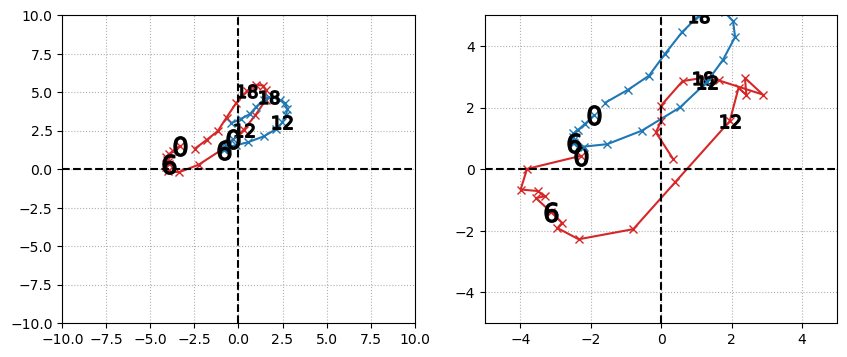

In [20]:
def plot_hodo(u,v,color="tab:blue"):
    u = u.values
    v = v.values
    plt.plot(u,v,color=color,marker="x")
    [plt.plot(u[i],v[i],color="k",marker="$"+str(i)+"$",ms=14) for i in [0,6,12,18]]
    
plt.figure(figsize=[10,4])

plt.subplot(1,2,1)

plot_hodo(
    F_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    F_sb_comp["vas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    color="tab:red"
)

plot_hodo(
    F_non_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    F_non_sb_comp["vas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    color="tab:blue"
)

plt.ylim([-10,10])
plt.xlim([-10,10])
plt.gca().axhline(ls="--",color="k")
plt.gca().axvline(ls="--",color="k")
plt.gca().grid(ls=":")


plt.subplot(1,2,2)

plot_hodo(
    sbi_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    sbi_sb_comp["vas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    color="tab:red"
)

plot_hodo(
    sbi_nonsb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    sbi_nonsb_comp["vas"].sel(lat=perth_lat,lon=perth_lon,method="nearest"),
    color="tab:blue"
)

plt.ylim([-5,5])
plt.xlim([-5,5])
plt.gca().axhline(ls="--",color="k")
plt.gca().axvline(ls="--",color="k")
plt.gca().grid(ls=":")

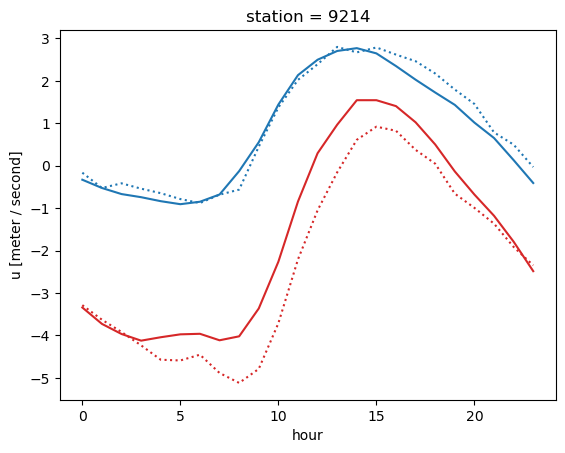

In [24]:
F_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:red")
F_non_sb_comp["uas"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:blue")

obs_sb_hourly.u.plot(color="tab:red",ls=":")
obs_non_sb_hourly.u.plot(color="tab:blue",ls=":")

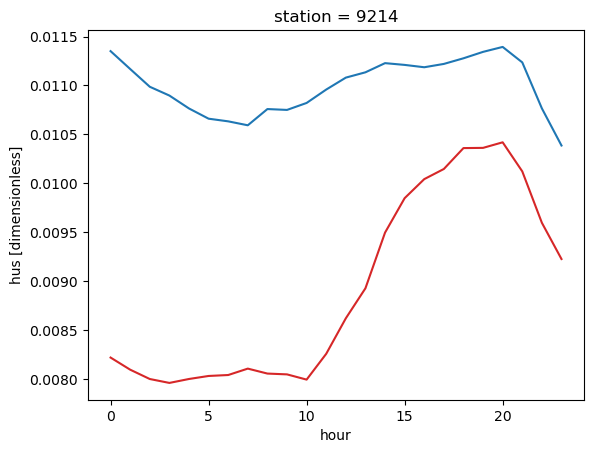

In [25]:
F_sb_comp["hus"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:red")
F_non_sb_comp["hus"].sel(lat=perth_lat,lon=perth_lon,method="nearest").plot(color="tab:blue")

obs_sb_hourly.hus.plot(color="tab:red",ls=":")
obs_non_sb_hourly.hus.plot(color="tab:blue",ls=":")